# Generalization with Multi Layer Perceptron (MLP) and scikit-learn
Using a MLP to recognize handwritten digits from Optical Recognition of Handwritten Digits Data Set (Lichman, 2003, UCI Machine Learning Repository)

Authors:
- Hugo Hernández Martín
- José Fenic Peiteado Padilla
- Adrián Mora Rodriguez
- Juan Rodríguez Suárez

Subject: Tratamiento Inteligente de Datos, ESIT-ULL

License: GNU GPL 3

Date: 27/04/2024

## References:
* Recognizing hand-written digits, scikit-learn: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py
* Generalizacion con LVQ, Patricio García: https://gitlab.com/pgarcia/OptdigitsLVQNeurolab/-/blob/master/Generalizacion_con_LVQ.ipynb

## ToDo:
* Use a scaler from sklearn.preprocessing (not /= 16)


## Carga de librerías
Se utilizan las librerías de numpy, matplotlib, sklearn, pandas e imblearn:

- Pandas se está usando para la lectura del fichero con los datos y el manejo del dataframe.
- imblearn se está usando para el balanceo de clases.

In [26]:
# Library imports
# ------------
# Standard scientific Python imports
# python3 -mpip install numpy
# python3 -mpip install matplotlib
# sudo apt-get install python-tk
import numpy as np
import matplotlib.pyplot as plt

# Import from imblearn
import imblearn
from imblearn.over_sampling import SMOTE

# Import from pandas
import pandas as pd

from sklearn.preprocessing import MinMaxScaler



# Import from scikit-learn
from sklearn import datasets
# from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Import from datetime
from datetime import datetime

# Increase de figure size
plt.rcParams['figure.dpi'] = 150


## Carga y visualización de datos
Se cargan a memoria los datos, leyendo desde un fichero CSV mediante la librería pandas, también normalizando y dividiendo en conjuntos de entrenamiento, testeo y validación:

In [46]:
# Load the digits dataset
dataset = pd.read_csv("bank-additional-full.csv", delimiter=';')

print(dataset)
print(dataset.dtypes)
print(dataset.describe())

for column in dataset.columns:
    if dataset[column].dtype == object and column != 'y':
        # Aplicar One-Hot Encoding a cada columna categórica
        dummies = pd.get_dummies(dataset[column], prefix=column)
        # Eliminar la columna original categórica
        dataset = dataset.drop(column, axis=1)
        # Concatenar las columnas codificadas con el resto del dataframe
        dataset = pd.concat([dataset, dummies], axis=1)

print(dataset.head())

# Convertir la columna objetivo a un valor numérico
dataset['y'] = dataset['y'].map({'no': 0, 'yes': 1})


# Tratar unkonwn
for column in dataset.columns:
    mode = dataset[column].mode()[0]
    dataset[column] = dataset[column].replace('unknown', mode)

print('Datos faltantes:\n' + str(dataset.isnull().sum()))


# Normalizar los datos
scaler = MinMaxScaler()
data_normalized = dataset.copy()  # Crear una copia del DataFrame original

# Normalizar cada columna por separado
for column in dataset.columns:
    # Comprobar el tipo de dato de la columna
    if dataset[column].dtypes == 'int64' or dataset[column].dtypes == 'float64':
        data_normalized[column] = scaler.fit_transform(dataset[[column]])

print(data_normalized)

training, test = train_test_split(data_normalized, test_size=0.2, random_state=0, shuffle=True)

print(training.shape)
print(test.shape)

train, valid = train_test_split(training, test_size=0.25, random_state=0, shuffle=True)

print(train.shape)
print(valid.shape)
print(valid['y'].value_counts())


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  

Se visualizan los datos en gráficas que muestran la distribución de los valores para cada variable.

In [ ]:
# Data visualization
# ------------
# have a look at the first test images

for column in dataset.columns:
  if column == 'pdays':
    plt.hist(dataset[column], bins=50)
    plt.title(column + ' distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()
    continue
  plt.bar(dataset[column].unique(), dataset[column].value_counts())
  plt.title(column + ' distribution')
  plt.xlabel(column)
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.show()


## Preprocesado de datos
Los datos de entrada serán las imágenes de 8x8 elementos convenientemente preprocesadas, como salida deseada se usa la categoría (el dígito que supuestamente se escribió). {En otros datos habrá de elegirse las entradas y salidas de acuerdo al problema a plantear. Para clasificación es necesario que las salidas sean algún dato categórico. Los errores producidos estarán muy relacionados con el problema a tratar, así por ejemplo detectar el sexo de una persona a partir de los síntomas de la enfermedad que tiene posiblemente sea más complicado que determinar la enfermedad a partir de los síntomas.}

Se realiza una partición de los datos, reservando el 75% de los datos del primer conjunto para entrenamiento, el otro 25% para validación y todos los datos cargados del segundo conjunto para test. Se barajean el conjunto de entrenamiento. {Si tiene un único conjunto de datos a dividir una partición de 50% entrenamiento, 25% validación y 25% test podría estar bien siempre que el conjunto de datos de entrenamiento no quede excesivamente grande o pequeño. Habrá de realizarse una validación con al menos un conjunto de entrenamiento y otro de validación si dispone de pocos datos, una partición de 75% y 25% podría estar bien en ese caso.}

Luego escalamos los datos de entrada dividiendo entre 16 para obtener datos en el rango entre 0 y 1. {El escalado o nomalización a utilizar es muy dependiente del tipo de problema y tipos de datos de que se disponga, consúltenme si tienen dudas.}

La distribución de datos por clases es bastante homogénea, por lo tanto se puede considerar bien balanceado. {En el caso de que esto no sea así se podría plantear un balanceo de datos para evitar que las clases con menos datos obtengan malos resultados.}

Preprocessing data, 80% for training and 20% for validation
Preprocessing training data, 75% for training and 25% for validation
        age  duration  campaign  pdays  previous  emp.var.rate  \
0  0.481481  0.058967  0.036364    1.0  0.142857      0.333333   
1  0.197531  0.052257  0.000000    1.0  0.000000      0.104167   
2  0.148148  0.072590  0.109091    1.0  0.000000      1.000000   
3  0.123457  0.072590  0.036364    1.0  0.000000      1.000000   
4  0.358025  0.033347  0.000000    1.0  0.000000      0.104167   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month_sep  \
0        0.269680       0.192469   0.163228     0.512287  ...      False   
1        0.104443       0.719665   0.092949     0.425709  ...      False   
2        0.669135       0.338912   0.980050     1.000000  ...      False   
3        0.669135       0.338912   0.980730     1.000000  ...      False   
4        0.000000       0.811715   0.054183     0.425709  ...      False   

   day_of_week_fr

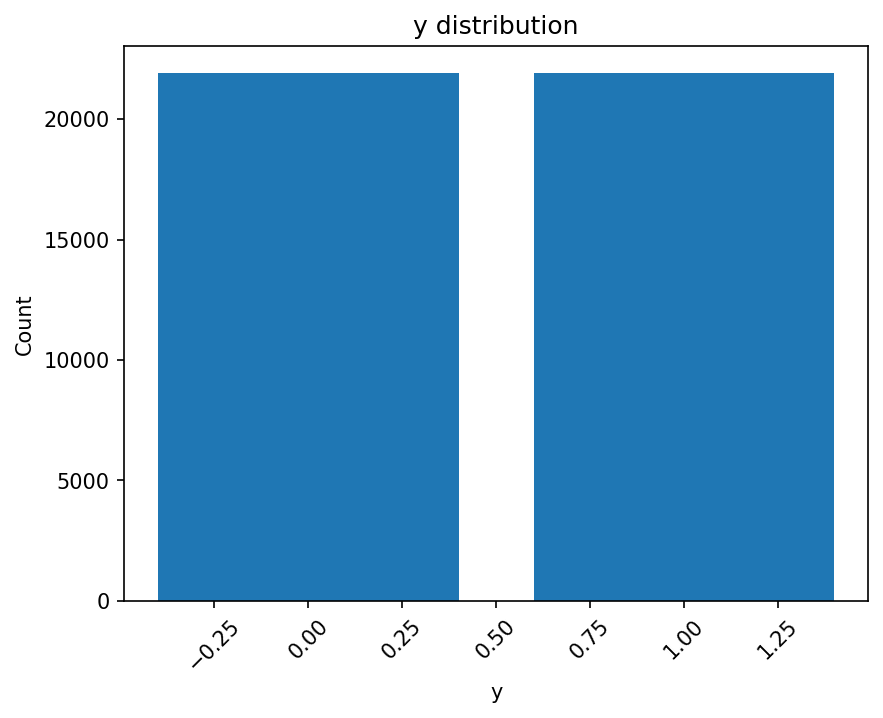

Number of patterns in train set: 24712
Number of patterns in valid set: 8238
Number of patterns in test set: 8238


In [47]:
# Data preprocessing
# ------------

print("Preprocessing data, %d%% for training and %d%% for validation" % (80, 20))
print("Preprocessing training data, %d%% for training and %d%% for validation" % (75, 25))

# Balancear los datos de entrenamiento
# ------------
# Definir la función para balancear los datos con SMOTE
def balance_data_with_smote(X, y):
    sm = SMOTE(random_state=42)
    X_oversampled, y_oversampled = sm.fit_resample(X, y)
    X_balanced = pd.DataFrame(X_oversampled, columns=X.columns)
    y_balanced = pd.Series(y_oversampled)
    return X_balanced, y_balanced

# Preparar y aplicar SMOTE al conjunto de entrenamiento
categorical_columns = [col for col in train.columns if train[col].dtype == 'object']
x_train = train.drop(columns=categorical_columns + ['y'])
y_train = train['y']

x_train_balanced, y_train_balanced = balance_data_with_smote(x_train, y_train)
# Convertir y_train_balanced a DataFrame si aún no lo es
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['y'])

# Concatenar x_train_balanced con y_train_balanced_df a lo largo del eje de las columnas
train_balanced = pd.concat([x_train_balanced, y_train_balanced_df], axis=1)

# Ahora train_balanced es un DataFrame que contiene tanto las características como las etiquetas balanceadas
print(train_balanced.head())


plt.bar(train_balanced["y"].unique(), train_balanced["y"].value_counts())
plt.title('y distribution')
plt.xlabel('y')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Print data sets cardinality
print("Number of patterns in train set: %d" % len(train))
print("Number of patterns in valid set: %d" % len(valid))
print("Number of patterns in test set: %d" % len(test))


## Resultados iniciales Perceptrón Simple

Se entrena el modelo Perceptrón Simple con 30 iteraciones, que nos dará la medida de hasta que punto el problema es separable linelamente. {El número de iteraciones puede variar para sus datos, asegúrense que el error ha descendido y parece no poder descender mucho más.}:

In [52]:
# Modeling Perceptron
# ------------
max_iter = 30

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter)

#train_balanced = train_balanced[[col for col in train_balanced.columns if col != 'y'] + ['y']]
valid = valid[[col for col in valid.columns if col != 'y'] + ['y']]
per = Perceptron(max_iter=max_iter, shuffle=False, verbose=True)
# 
copia = train_balanced.copy()
copia.drop(columns=['y'])
per.fit(copia, train_balanced["y"])
#Mover la columna y al final

# Results
print("Printing Perceptron results")
#Quitar train_balanced["y"] de las características
copia_valid = valid.copy()
copia_valid.drop(columns=['y'])
predict_train = per.predict(copia)
predict_valid = per.predict(copia_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(train_balanced["y"], predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(valid["y"], predict_valid) * 100))


Learning a Perceptron with 30 maximum number of iterations and ...
-- Epoch 1
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 43854, Avg. loss: 0.001925
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 87708, Avg. loss: 0.000000
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 131562, Avg. loss: 0.000000
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 175416, Avg. loss: 0.000000
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 219270, Avg. loss: 0.000000
Total training time: 0.03 seconds.
-- Epoch 6
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 263124, Avg. loss: 0.000000
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 20.05, NNZs: 32, Bias: -2.000000, T: 306978, Avg. loss: 0.000000
Total training time: 0.04 seconds.
Convergence after 7 epochs took 0.04 seconds
Printing Perceptron results
Train accuracy: 100.000%
Valid accuracy: 10

Se observa que el problema no es separable linealmente, aunque los resultados aparentan ser buenos dado las imágenes vistas.

## Resultados iniciales MLP
Se define la función *MLP_train_valid* para poder realizar entrenamientos del Perceptrón Multicapa (MLP) incluyendo validaciones con el conjunto de validación y *early stopping*, así como mostrar opcionalmente resultados y logs:

In [14]:
# Modeling MLP
# ------------
# Function to training and validate MLP
def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
    """
    Train and valid MLP every valid_cycles iterations
    """
    classes  = np.unique(target_train)
    loss_valid = []
    for i in range(max_iter//valid_cycles):
        for j in range(valid_cycles):
            out = mlp.partial_fit(input_train, target_train, classes)
            # Calculate loss function of valid set
        last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
        loss_valid.append(last_lost_valid)
        if verbose:
            print("Iteration %d, train loss = %.8f, valid loss = %.8f" %
                  (mlp.n_iter_, mlp.loss_, last_lost_valid))
        if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
            if verbose:
                print("Early stopping: Validation score did not improve")
            break
    if verbose: print(out)
    
    if verbose:
        # Visualizing the Cost Function Trajectory
        # (https://sdsawtelle.github.io/blog/output/week4-andrew-ng-machine-learning-with-python.html#Visualizing-the-Cost-Function-Trajectory)
        print("Visualizing the Cost Function Trajectory")
        plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
        plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
        plt.xlabel('number of iterations')
        plt.ylabel('loss function')
        plt.legend(loc='upper right')
        plt.show()

Se realiza un entrenamiento con un MLP de una capa oculta de 60 neuronas, un ratio de aprendizaje de 0,001, durante un máximo 300 iteraciones, validando cada 5 ciclos. Se muestra la gráfica de la evolución del error a lo largo de los ciclos. {Utilicen un número de neuronas inicial que se encuentre entre el número de entradas y el número de salidas. Elija el número de iteraciones de forma que gráfica de la evolución del error acabe plana}:

Learning a MLP with 60 hidden neurons, 300 maximum number of iterations and 0.00100000 learning rate ...
Iteration 5, train loss = 1.45721410, valid loss = 1.34168537
Iteration 10, train loss = 0.68608528, valid loss = 0.64179998
Iteration 15, train loss = 0.37861924, valid loss = 0.37121381
Iteration 20, train loss = 0.26170688, valid loss = 0.26460368
Iteration 25, train loss = 0.20134851, valid loss = 0.20812804
Iteration 30, train loss = 0.16532717, valid loss = 0.17446236
Iteration 35, train loss = 0.14047095, valid loss = 0.15175895
Iteration 40, train loss = 0.12216185, valid loss = 0.13546013
Iteration 45, train loss = 0.10821937, valid loss = 0.12397071
Iteration 50, train loss = 0.09715307, valid loss = 0.11520259
Iteration 55, train loss = 0.08811606, valid loss = 0.10842173
Iteration 60, train loss = 0.08048975, valid loss = 0.10295672
Iteration 65, train loss = 0.07400960, valid loss = 0.09866531
Iteration 70, train loss = 0.06837748, valid loss = 0.09521559
Iteration 75, 

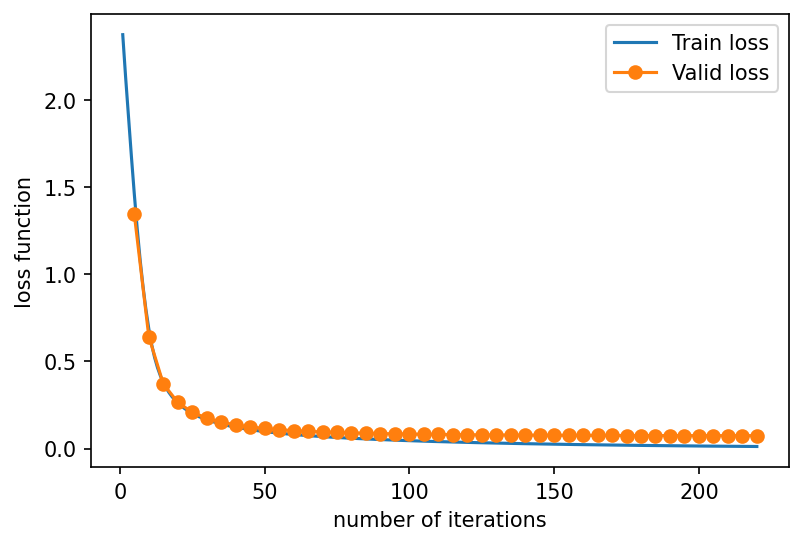

In [15]:
# Multilayer Percetron wiht n_hidden hidden neurons
n_hidden = 60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True

print("Learning a MLP with %d hidden neurons, %d maximum number of iterations and %.8f learning rate ..." % (n_hidden, max_iter, learning_rate_init))

mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=False)

MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, True)


Se ve que los errores descienden y se estabilizan, no se produce sobreentrenamiento y el entrenamiento es detenido a las 220 iteraciones. Se muestran los resultados iniciales de este entrenamiento {Si no consiguen inicialmente un entrenamiento estable inténtenlo cambiando el número de neuronas ocultas o el ratio de aprendizaje}:

In [16]:
# Intitial results
# ------------
print("Printing initial results")

predict_train = mlp.predict(input_train)
predict_valid = mlp.predict(input_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))


Printing initial results
Train accuracy: 99.965%
Valid accuracy: 97.699%
Train confusion matrix:
[[275   0   0   0   0   0   0   0   0   0]
 [  0 289   0   0   0   0   0   0   0   0]
 [  0   0 284   0   0   0   0   0   0   0]
 [  0   0   0 294   0   1   0   0   0   0]
 [  0   0   0   0 299   0   0   0   0   0]
 [  0   0   0   0   0 290   0   0   0   0]
 [  0   0   0   0   0   0 281   0   0   0]
 [  0   0   0   0   0   0   0 292   0   0]
 [  0   0   0   0   0   0   0   0 281   0]
 [  0   0   0   0   0   0   0   0   0 281]]
Valid confusion matrix:
[[98  0  1  0  0  0  1  0  1  0]
 [ 0 97  0  0  0  0  0  2  1  0]
 [ 0  0 95  0  0  0  1  0  0  0]
 [ 0  0  0 94  0  0  0  0  0  0]
 [ 0  0  0  0 85  0  1  0  0  2]
 [ 0  0  0  1  0 82  0  0  0  3]
 [ 0  1  0  0  0  0 95  0  0  0]
 [ 0  0  0  0  0  0  0 95  0  0]
 [ 0  1  0  1  0  0  2  0 95  0]
 [ 0  0  0  1  1  0  0  0  1 98]]
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00

En estos resultados iniciales se ve que MLP mejora respecto al Perceptrón en un 3,453% y un 2,406% para los conjuntos de entrenamiento y validación respectivamente. Lo que indica que eliminando la limitación de separabilidad lineal se consiguen mejoras con el conjunto de entrenamiento, no tanto en el conjunto de validación.

## Optimización ratio de aprendizaje
Para acelerar la convergencia de los MLP se busca un ratio de aprendizaje más adecuado, probando con distintos valores entre 0,001 y 0,1, utilizando la función de activación por defecto ReLU. Se visualizan las gráficas de la evolución del error a lo largo de los ciclos para los distintos ratios de aprendizajes estudiados {Utilicen un rango de ratios de aprendizajes en que se vean inestabilidades en sus valores más altos. Utilizando la función de activación 'logistic' quizás podrían obtener bajadas más estables, a costa de sacrificar el tiempo de ejecución}:

Learning rate optimization
Number of seconds for training: 18
Visualizing the Cost Function Trajectory with different learning rates


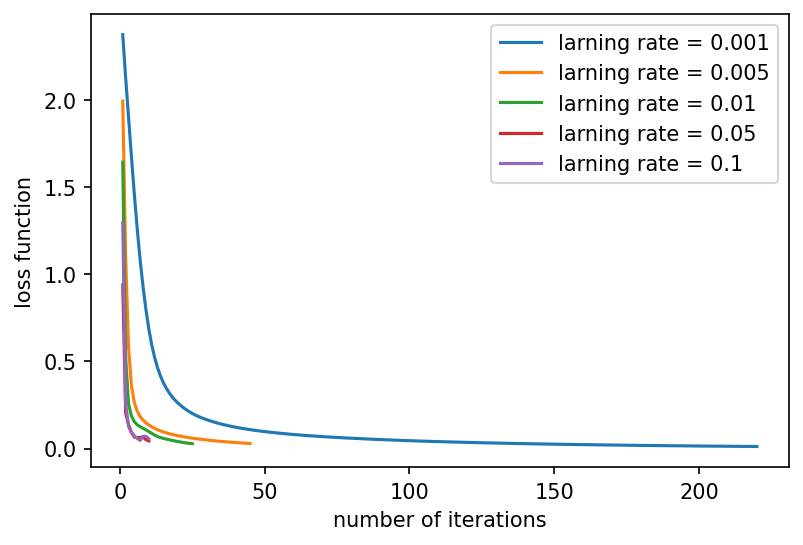

In [17]:
# Learning rate optimization
# ------------
# Test with different learning_rate_init
print("Learning rate optimization")

tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0

now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
    mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
    MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
    
    loss_curves.append(mlp.loss_curve_)

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())

# Show results
print("Visualizing the Cost Function Trajectory with different learning rates")
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
    plt.plot(range(1, len(loss_curve)+1), loss_curve, label='larning rate = ' + str(lr))

plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()


Viendo en detalle de la gráfica vemos que el ratio de aprendizaje 0,005 parece el más adecuado, al entrenar de forma estable en menos de 60 iteraciones.

## Optimización arquitectura MLP
Para tratar de mejorar los resultados del MLP se estudia el número de neuronas ocultas más adecuadas, probando con distintos valores entre 10 y 190, repitiendo parar cada configuración 10 veces y quedándose con aquella de mayor precisión en el conjunto de validación {. El número de neuronas ocultas a estudiar deben adaptarlas a sus datos, de forma que haya variabilidad en los resultados obtenidos. Este estudio puede conllevar mucho tiempo de cómputo}:

In [18]:
# Architecture optimization
# ------------
print("Architecture optimization")

# Test MLP with differents number of hidden units and several repetitions
tests_n_hidden = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
n_reps = 10
# n_reps = 20
activation = 'relu'
# activation = 'logistic'
# learning_rate_init = 0.001
# learning_rate_init = 0.01
learning_rate_init = 0.005

now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
        MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
        
        acc_train = accuracy_score(target_train, mlp.predict(input_train))
        acc_valid = accuracy_score(target_valid,mlp.predict(input_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_mlp = mlp
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)

Architecture optimization
Seed = 0, train acc = 0.98709452, valid acc = 0.96652720, iterations = 105
Seed = 1, train acc = 0.98116498, valid acc = 0.96129707, iterations = 85
Seed = 2, train acc = 0.98848971, valid acc = 0.97907950, iterations = 85
Seed = 3, train acc = 0.98988490, valid acc = 0.97175732, iterations = 90
Seed = 4, train acc = 0.99093129, valid acc = 0.96966527, iterations = 90
Seed = 5, train acc = 0.98430415, valid acc = 0.96234310, iterations = 90
Seed = 6, train acc = 0.99302407, valid acc = 0.97071130, iterations = 105
Seed = 7, train acc = 0.99162888, valid acc = 0.97280335, iterations = 95
Seed = 8, train acc = 0.98116498, valid acc = 0.96443515, iterations = 80
Seed = 9, train acc = 0.98500174, valid acc = 0.96757322, iterations = 90
Number hidden units = 10, train acc = 0.98848971, max valid acc = 0.97907950
Seed = 0, train acc = 0.99441925, valid acc = 0.98012552, iterations = 60
Seed = 1, train acc = 0.99720963, valid acc = 0.97803347, iterations = 70
Seed = 

Se observa que el mejor MLP encontrado resulta ser con 50 neuronas en la capa oculta. Se visualizan los resultados de errores obtenidos con las distintas arquitecturas estudiadas. {Utilicen un rango de neuronas ocultas en que se vea empeoramiento del error en sus valores más bajos y variaciones poco significativas en valores más altos. Nunca el mejor resultado encontrado debe estar en un extremo del intervalo}:

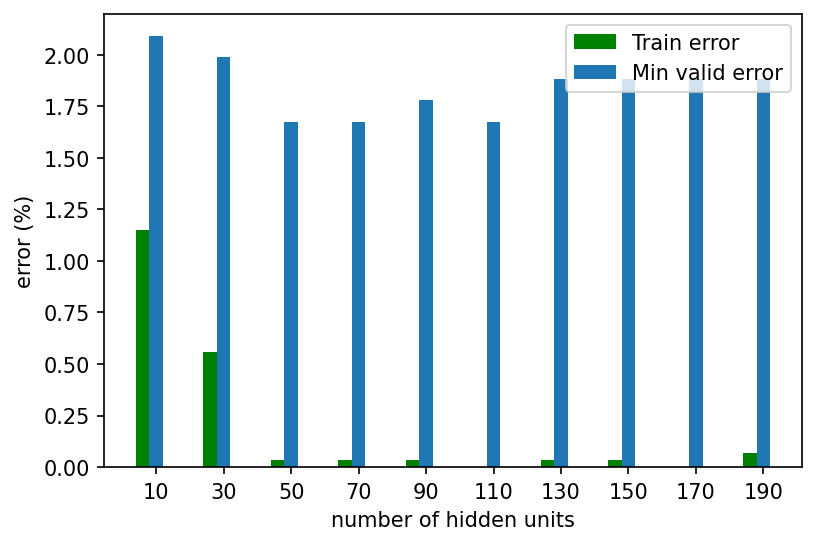

In [19]:
# Show results
width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()

Se observa que neuronas ocultas entre 50 y 190 los resultados son similares, con variaciones poco significativas. {Si consideran mejor algún otro MLP no duden en utilizarlo.}

## Resultados finales mejor MLP
Se calculan los resultados finales para el mejor MLP obtenido, incluido el conjunto de test {Es importante no haber utilizado nunca el conjunto de test como guía para ajustar la arquitectura o parámetros}:

In [20]:
# Final results of best MLP
# ------------

print("Printing final results")

predict_train = best_mlp.predict(input_train)
predict_valid = best_mlp.predict(input_valid)
predict_test = best_mlp.predict(input_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results
Train accuracy: 99.965%
Valid accuracy: 98.326%
Test accuracy: 95.938%
Train confusion matrix:
[[275   0   0   0   0   0   0   0   0   0]
 [  0 289   0   0   0   0   0   0   0   0]
 [  0   0 284   0   0   0   0   0   0   0]
 [  0   0   0 294   0   1   0   0   0   0]
 [  0   0   0   0 299   0   0   0   0   0]
 [  0   0   0   0   0 290   0   0   0   0]
 [  0   0   0   0   0   0 281   0   0   0]
 [  0   0   0   0   0   0   0 292   0   0]
 [  0   0   0   0   0   0   0   0 281   0]
 [  0   0   0   0   0   0   0   0   0 281]]
Valid confusion matrix:
[[99  0  1  0  0  0  1  0  0  0]
 [ 0 98  0  0  0  0  0  2  0  0]
 [ 0  0 95  0  0  0  0  0  1  0]
 [ 0  0  0 94  0  0  0  0  0  0]
 [ 0  0  0  0 87  0  1  0  0  0]
 [ 0  0  0  1  0 83  0  0  0  2]
 [ 0  1  0  0  0  0 95  0  0  0]
 [ 0  0  0  0  0  0  0 95  0  0]
 [ 0  1  0  0  1  0  0  0 97  0]
 [ 0  0  0  2  1  0  0  0  1 97]]
Test confusion matrix:
[[176   0   0   0   0   2   0   0   0   0]
 [  0 178   0   0   0   0   2 

Se observa que los resultados finales del mejor MLP obtenido mejoran respecto al Perceptrón un 3,453% y un 3,033% para los conjuntos de entrenamiento y validación respectivamente, mejorando la generalización respecto al MLP inicial en un  un 0,627%. El error final parar el conjunto de test es 95,938%, un 2,388% peor que el conjunto de validación. En la matriz de confusión y el informe de clasificación del conjunto de test se aprecia que el dígito con mayores problemas de reconocimiento resulta ser el 8.

Se muestran también las curvas ROC para el conjunto de test, en ella también se puede ver que la clase del dígito 8 es la peor predicha:

Printing ROC curves of test set


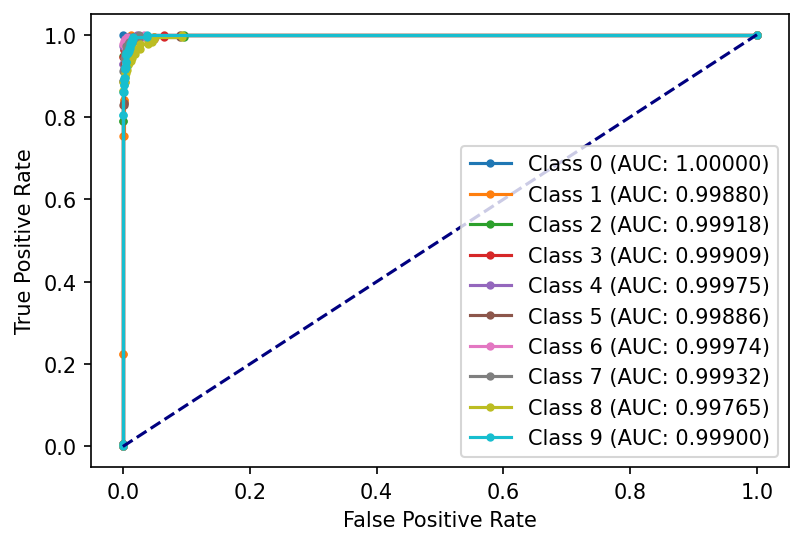

In [21]:
# ROC curves of test set
mlp_probs = mlp.predict_proba(input_test)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
    mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
    fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
    mlp_fpr.append(fpr)
    mlp_tpr.append(tpr)

print("Printing ROC curves of test set")
# plot the roc curve for the model
for cla in classes:
    # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))

# axis labels
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Finalmente se muestran imágenes de distintos errores producidos en patrones del conjunto de test pertenecientes a la clase real 8:

Showing first 8 errors of real class 8


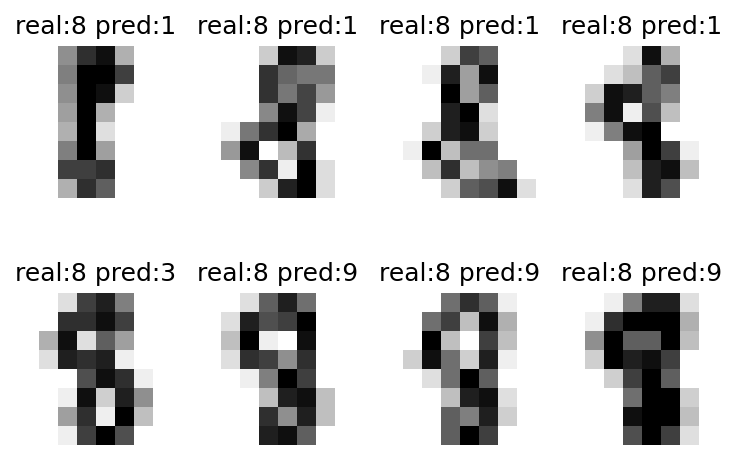

In [22]:
# Show errors on real class 8
real_class = 8
indxs = np.where(digits_test.target == real_class)[0]
indxs_err = indxs[(np.where(predict_test[(indxs)] != real_class)[0])]
preds_err = predict_test[(indxs_err)]
n_img_plt = 8

print("Showing first %d errors of real class %d" % (n_img_plt, real_class))

_, axes = plt.subplots(2, n_img_plt//2)
images_and_labels = list(zip(digits_test.images[(indxs_err)], digits_test.target[(indxs_err)], preds_err))
for ax, (image, label1, label2) in zip(np.concatenate(axes), images_and_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('real:%i pred:%i' % (label1, label2))

plt.show()

## Conclusiones
El error final parar el conjunto de test, mucho peor que el conjunto de validación, puede estar justificado en parte debido a que los autores (escritores) del conjuntos de test son distintos a los autores de los conjuntos de entrenamieto y validación, donde si son los mismos. Los problemas que se aprecia que con el dígito 8 resultas ser lógicos, en la medida que la representación de un número tan denso en una matriz tan escasa resulta complicada, como se observa en la imagne de dichos errores. Esto nos induce a pensar que utilizando matrices mas grandes, como por ejemplo las utilizadas en el conjunto de datos MINIST, se podrían obtener resultados aún mejores.

Este resultado final parece bastante aceptable, y por ejemplo supera en 2% al mejor resultado obtenido en la publicación (Tang, Ponnuthurai, Suganthan, Yao and Qin, 2005) (93,93% de accurracy con WLDR 9d). {Si pueden comparara los resultados por los publicados por otros autores, mucho mejor.}